# Citation_vis

A notebook to visualize citations over time using the openalex [1] API

[1] Priem, J., Piwowar, H., & Orr, R. (2022). OpenAlex: A fully-open index of scholarly works, authors, venues, institutions, and concepts. ArXiv. https://arxiv.org/abs/2205.01833

In [1]:
# Import required packages
import requests
import matplotlib.pyplot as plt
import pandas as pd

In [2]:
def get_citation_data(doi, cutoff_years=(2010,2024)):
    """
    Retrieve citation data from the OpenAlex API for a specific DOI.

    Parameters:
        doi (str): Digital Object Identifier (DOI) of the publication
        cutoff_years (tuple): Range of years to consider for citation data

    Returns:
        date (str): Publication date
        years (list): List of years with citation counts
        counts (list): Citation counts corresponding to each year
    """
    url = f"https://api.openalex.org/works/doi/{doi}"
    response = requests.get(url)  # Fetch data from the API
    data = response.json() # Parse JSON response
    id = data["id"]
    date = data['publication_date']

    url = f"https://api.openalex.org/works?group_by=publication_year&per_page=200&filter=cites:{id}"
    response = requests.get(url)
    data = response.json()
    
    # Extract publication date and citation data by year
    years = [int(x["key"]) for x in data['group_by'] if (int(x["key"])>=cutoff_years[0] and int(x["key"])<=cutoff_years[1])]
    counts = [x["count"] for x in data['group_by'] if (int(x["key"])>=cutoff_years[0] and int(x["key"])<=cutoff_years[1])]
    
    return date, years, counts


def get_plot_data(publications):
    """
    Process and aggregate citation data for each tool for plotting.

    Parameters:
        publications (DataFrame): DataFrame with columns 'Name' and 'DOI' for each tool

    Returns:
        plot_data (DataFrame): Processed DataFrame with aggregated citation counts by year for each tool
    """
    name, years, counts = [], [], []
    date = {}  # Dictionary to store each tool's publication date

    # Loop through each row of the publications DataFrame
    for row in publications.iterrows():
        row = row[1]
        name_tool = row["Name"]

        # Get citation data for each tool
        date_tool, years_tool, counts_tool = get_citation_data(row["DOI"])

        # If there are no citations, initialize year and count with publication year
        if len(years_tool) == 0:
            years_tool += [int(date_tool.split('-')[0])]
            counts_tool += [0]

        # Add citation data for the tool
        name += len(years_tool) * [name_tool]
        years += years_tool
        counts += counts_tool

        # Store the earliest publication date for each tool
        if name_tool in date.keys():
            if int(date[name_tool].split('-')[0]) < int(date_tool.split('-')[0]):
                continue
        date[name_tool] = date_tool  
    
    # Create DataFrame with collected data
    plot_data = pd.DataFrame({"Name": name, "Year": years, "Count": counts})

    # Filter out data points from before the publication year of each tool
    for tool, pub_date in date.items():
        plot_data = plot_data[~((plot_data['Name'] == tool) & (plot_data['Year'] < int(pub_date.split('-')[0])))]

    # Aggregate citation counts for each tool by year
    plot_data = plot_data.groupby(['Name', 'Year'], as_index=False).agg({'Count': 'sum'})

    # Sort tools by publication date
    sorted_names = sorted(date, key=date.get)
    plot_data['Name'] = pd.Categorical(plot_data['Name'], categories=sorted_names, ordered=True)
    plot_data = plot_data.sort_values('Name')

    return plot_data


def draw_plot(plot_data, custom_colors=True):
    """
    Generate a scatter plot with marginal histograms for citation counts over time.

    Parameters:
        plot_data (DataFrame): Processed DataFrame with citation counts for each tool over time

    Returns:
        fig (Figure): Matplotlib figure containing the scatter plot with marginal histograms
    """
    # Initialize a square figure
    fig = plt.figure(figsize=(8, 6))

    # Configure grid layout with two rows and two columns
    gs = fig.add_gridspec(2, 2, width_ratios=(4, 1), height_ratios=(1, 4),
                          left=0.1, right=0.9, bottom=0.1, top=0.9,
                          wspace=0.05, hspace=0.05)

    # Define main scatter plot and histograms for marginal distributions
    ax = fig.add_subplot(gs[1, 0])  # Main scatter plot
    ax_histx = fig.add_subplot(gs[0, 0], sharex=ax)  # Histogram for years
    ax_histy = fig.add_subplot(gs[1, 1], sharey=ax)  # Bar plot for total citations

    # Create a color map for unique tools
    unique_names = plot_data['Name'].unique()
    num_unique_names = len(unique_names)
    if custom_colors:
        hex_codes = ['#007FFF', '#B1DDF0', '#FF7800', '#2EC27E', '#8FF0A4', '#F8CECC', '#B266FF', '#A0522D', '#BAC8D3']*10
        colors = plt.cm.colors.ListedColormap(hex_codes)
    else:
        colors = plt.get_cmap('tab20', num_unique_names) 

    # Map each name to a unique color
    color_map = {name: colors(i) for i, name in enumerate(unique_names)}

    # Add light gray horizontal lines
    ax.set_axisbelow(True)  # Ensures grid lines are behind the scatter plot
    ax.yaxis.grid(True, which='major', linestyle='--', linewidth=0.5, color='lightgray')

    # Scatter plot with varying size based on citation counts
    ax.scatter(plot_data['Year'], plot_data['Name'], 
                s=plot_data['Count'] / max(plot_data['Count']) * 1000, 
                alpha=0.7, 
                color=[color_map[name] for name in plot_data['Name']])
    
    ax.set_xlabel('Year')

    # Aggregate total citations for each tool and plot on the side bar chart
    tool_counts = plot_data.groupby('Name', observed=True)['Count'].sum().reindex(sorted(plot_data['Name'].unique())).values
    ax_histy.barh(sorted(plot_data['Name'].unique()), tool_counts, 
                   color=[color_map[name] for name in sorted(plot_data['Name'].unique())], alpha=0.7)

    # Create histogram for marginal distribution by years
    year_counts = plot_data.groupby('Year', observed=True)['Count'].sum().reindex(sorted(plot_data['Year'].unique())).values
    ax_histx.bar(sorted(plot_data['Year'].unique()), year_counts, color='black', alpha=0.5)

    # Adjust axis limits and remove unnecessary borders
    ax_histx.set_xlim(ax.get_xlim())
    for histogram_ax in [ax_histx, ax_histy]:
        histogram_ax.spines['top'].set_visible(False)
        histogram_ax.spines['right'].set_visible(False)
    ax_histy.spines['left'].set_visible(False)
    ax_histx.spines['bottom'].set_visible(False)
    ax_histx.get_xaxis().set_visible(False)
    ax_histy.set_xlabel('Citations\nper tool')
    ax_histx.set_ylabel('Citations\nper year')
    ax_histy.get_yaxis().set_visible(False)

    # Set x-axis ticks to full years
    years = sorted(plot_data['Year'].unique())  # Extract unique years in sorted order
    if len(years) > 20:
        years = list(range(min(years), max(years)+1))[::-3]
    elif len(years) > 10:
        years = list(range(min(years), max(years)+1))[::-2]
    else:
        years = list(range(min(years), max(years)+1))
    ax.set_xticks(years)                        # Set ticks to only those years
    ax.set_xticklabels(years)                   # Ensure ticks are labeled properly

    return fig


def get_citation_vis(file, custom_colors=True):
    """
    Generate and save a citation visualization for tools listed in the input file.

    Parameters:
        file (str): Path to the CSV file containing tool names and DOIs
    """"""
    Generate and save a citation visualization for tools listed in the input file.

    Parameters:
        file (str): Path to the CSV file containing tool names and DOIs
    """
    df = pd.read_csv(file)
    name = file[:-4]
    plot_data = get_plot_data(df)
    plot_data.sort_values(['Name', 'Year'], ascending=[True, False]).to_csv(f'{name}_plot_data.csv', index=False)
    fig = draw_plot(plot_data, custom_colors=custom_colors)
    fig.savefig(name+".png", format="png", bbox_inches="tight", dpi=1000)
    plt.show()

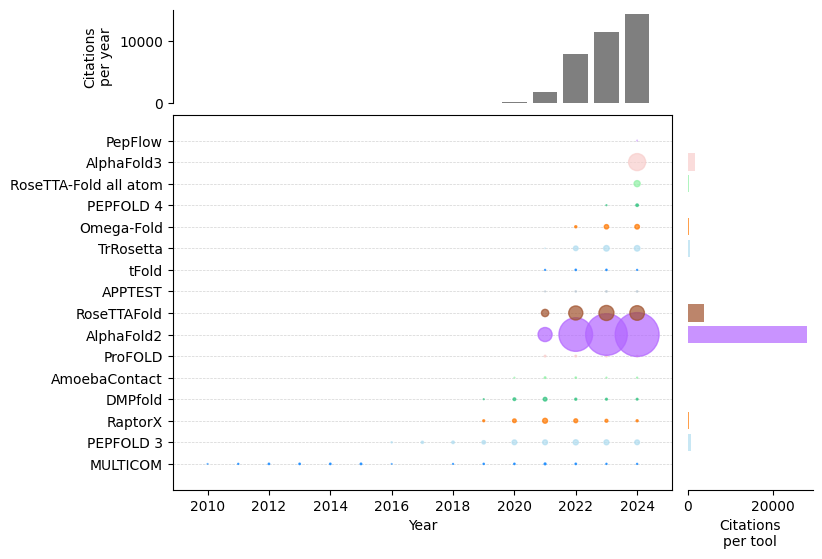

In [3]:
# Execute the visualization function with a sample CSV file
get_citation_vis("example.csv")
